## Поэкспериментируем с сегментацией

Уже известный нам датасет Oxford Pets содержит данные о сегментации кошек и собак.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)
dataset

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteNJI69Z/oxford_iiit_pet-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteNJI69Z/oxford_iiit_pet-test.tfrecord*...:   0%…

Dataset oxford_iiit_pet downloaded and prepared to ~/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


{'train': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

В датасете для каждой записи есть несколько полей: 
* `image` - изображение
* `label` - целевая метка (порода)
* `segmentation_mask` - маска сегментации, в которой для каждого пикселя отмечена одна из трёх категорий:
   - фон
   - кошка/собака
   - граничный пиксель

Кроме того, датасет разбит на обучающую и тестовую выборку.

Извлечем из датасета изображения и маски, при этом масштабируем до размера 128x128:

In [3]:
def load_image(x):
  input_image = tf.image.resize(x['image'], (128, 128))/255.0
  input_mask = tf.image.resize(x['segmentation_mask'], (128, 128))-1
  return input_image, input_mask

train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

for x,m in train_images:
  print(x.shape,m.shape)
  break

Опишем простейшую архитектуру модели классификации пикселей:
* На входе используем 1-2 свёрточных слоя с фильтрами 5x5 для выделения признаков. Важно использовать padding, чтобы размерность изображения не изменялась.
* Далее используем 1x1-convolution с тремя фильтрами для взвешивания признаков и получения на выходе one-hot encoding для трёх классов пикселей.

При этом в качестве функции потерь используем Sparse Categorical Crossentropy, не забывая применить softmax (за счет указания `from_logits=True`).

In [12]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(10,5,padding='same',input_shape=(128,128,3),activation='relu'),
    tf.keras.layers.Conv2D(20,5,padding='same',activation='relu'),
    tf.keras.layers.Conv2D(3,1,padding='same',activation=None)
])
model.summary()
model.compile('adam',tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),['acc'])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 128, 128, 10)      760       
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 20)      5020      
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 3)       63        
                                                                 
Total params: 5,843
Trainable params: 5,843
Non-trainable params: 0
_________________________________________________________________


Разбиваем датасет на минибатчи и перемешиваем перед обучением:

In [14]:
train_batch = train_images.cache().shuffle(1000).batch(32)
test_batch = test_images.cache().shuffle(1000).batch(32)

import numpy as np

#for x,y in train_batch:
#  print(x.shape,np.min(y),np.max(y))
#  break


In [20]:
hist = model.fit(train_batch,validation_data=test_batch,epochs=10)

Epoch 1/10
115/115 [==============================] - 3s 30ms/step - loss: 0.7135 - acc: 0.6691 - val_loss: 0.7103 - val_acc: 0.6748
Epoch 2/10
115/115 [==============================] - 3s 29ms/step - loss: 0.7081 - acc: 0.6738 - val_loss: 0.7121 - val_acc: 0.6734
Epoch 3/10
115/115 [==============================] - 3s 30ms/step - loss: 0.7083 - acc: 0.6732 - val_loss: 0.7069 - val_acc: 0.6768
Epoch 4/10
115/115 [==============================] - 3s 30ms/step - loss: 0.7068 - acc: 0.6744 - val_loss: 0.7161 - val_acc: 0.6716
Epoch 5/10
115/115 [==============================] - 3s 30ms/step - loss: 0.7055 - acc: 0.6752 - val_loss: 0.7153 - val_acc: 0.6722
Epoch 6/10
115/115 [==============================] - 3s 30ms/step - loss: 0.7090 - acc: 0.6730 - val_loss: 0.7116 - val_acc: 0.6733
Epoch 7/10
115/115 [==============================] - 3s 30ms/step - loss: 0.7041 - acc: 0.6753 - val_loss: 0.7081 - val_acc: 0.6769
Epoch 8/10
115/115 [==============================] - 3s 30ms/step - 

Точность получается не слишком высокой, посмотрим, как это выглядит визуально на тестовом датасете:

1/1 [==============================] - 0s 16ms/step
(5, 128, 128)


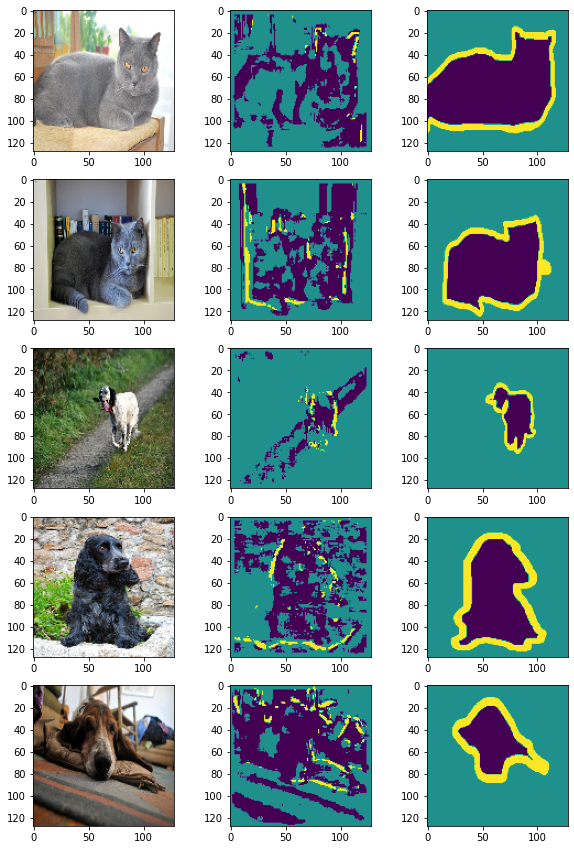

In [21]:
import matplotlib.pyplot as plt

for x,y in test_batch:
  break
pred = tf.argmax(model.predict(x[:5]),axis=-1)
print(pred.shape)
fig,ax = plt.subplots(5,3,figsize=(10,15))
for i,(x,y,p) in enumerate(zip(x[:5],y[:5],pred)):
  ax[i,0].imshow(x)
  ax[i,1].imshow(p)
  ax[i,2].imshow(tf.reshape(y,(128,128)))


Модель плохо определяет заполняемые области, поскольку свёртка смотрит только на небольшую окрестность каждого пикселя. Для понимания того, что весь силуэт кошки должен быть заполнен пикселями необходимо дойти до выделения признаков более высокого уровня. При этом надо понять, как спуститься назад на уровень попиксельной классификации.

## Пробуем U-Net

Такая проблема решается с помощью архитектуры U-Net. Идея состоит в том, что с одной стороны мы используем классическую пирамидальную архитектуру для выделения иерархии признаков, а с другой - обратную пирамидальную архитектуру, при этом подмешивая на вход каждого слоя как признаки с более высокоуровневого слоя, так и со слоя того же уровня энкодера.

In [25]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-20uc9eou
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-20uc9eou
  Created wheel for tensorflow-examples: filename=tensorflow_examples-e2510e7de8354ea89c54ab376ce52371efb39eff_-py3-none-any.whl size=299718 sha256=fc958a19fcc809a088ec71e0d94592fd46d72ce0ff34664e068adb19e7a7499b
  Stored in directory: /tmp/pip-ephem-wheel-cache-kn2ysaqq/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/i

In [26]:
from tensorflow_examples.models.pix2pix import pix2pix

Для извлечения признаков с разных уровней пирамиды CNN используем предобученную сеть MobileNet:

In [28]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Используем активацию с этих слоёв
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Модель для выделения признаков
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

Для обратной пирамиды апскейлинга используем функции upsample, которые определены в Tensorflow Examples:

In [29]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

inputs = tf.keras.layers.Input(shape=[128, 128, 3])

# Извлекаем признаки
skips = down_stack(inputs)
x = skips[-1]
skips = reversed(skips[:-1])

# Делаем upsampling
for up, skip in zip(up_stack, skips):
  x = up(x)
  concat = tf.keras.layers.Concatenate()
  x = concat([x, skip])

# Последний слой модели
last = tf.keras.layers.Conv2DTranspose(
    filters=3, kernel_size=3, strides=2,
    padding='same')  #64x64 -> 128x128

x = last(x)

unet = tf.keras.Model(inputs=inputs, outputs=x)

Получили модель `unet`, теперь обучаем её:

In [30]:
unet.compile('adam',tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),['acc'])
unet.fit(train_batch,validation_data=test_batch,epochs=10)

Epoch 1/10
115/115 [==============================] - 16s 110ms/step - loss: 0.4068 - acc: 0.8333 - val_loss: 0.3339 - val_acc: 0.8714
Epoch 2/10
115/115 [==============================] - 11s 100ms/step - loss: 0.2840 - acc: 0.8825 - val_loss: 0.3093 - val_acc: 0.8715
Epoch 3/10
115/115 [==============================] - 12s 102ms/step - loss: 0.2662 - acc: 0.8887 - val_loss: 0.2937 - val_acc: 0.8795
Epoch 4/10
115/115 [==============================] - 12s 104ms/step - loss: 0.2530 - acc: 0.8933 - val_loss: 0.2771 - val_acc: 0.8854
Epoch 5/10
115/115 [==============================] - 12s 100ms/step - loss: 0.2443 - acc: 0.8962 - val_loss: 0.2712 - val_acc: 0.8907
Epoch 6/10
115/115 [==============================] - 12s 101ms/step - loss: 0.2339 - acc: 0.9000 - val_loss: 0.2786 - val_acc: 0.8861
Epoch 7/10
115/115 [==============================] - 12s 101ms/step - loss: 0.2279 - acc: 0.9020 - val_loss: 0.2621 - val_acc: 0.8930
Epoch 8/10
115/115 [==============================] - 1

Видно, что точность намного выше! Посмотрим на то, как это выглядит:

1/1 [==============================] - 1s 1s/step
(5, 128, 128)


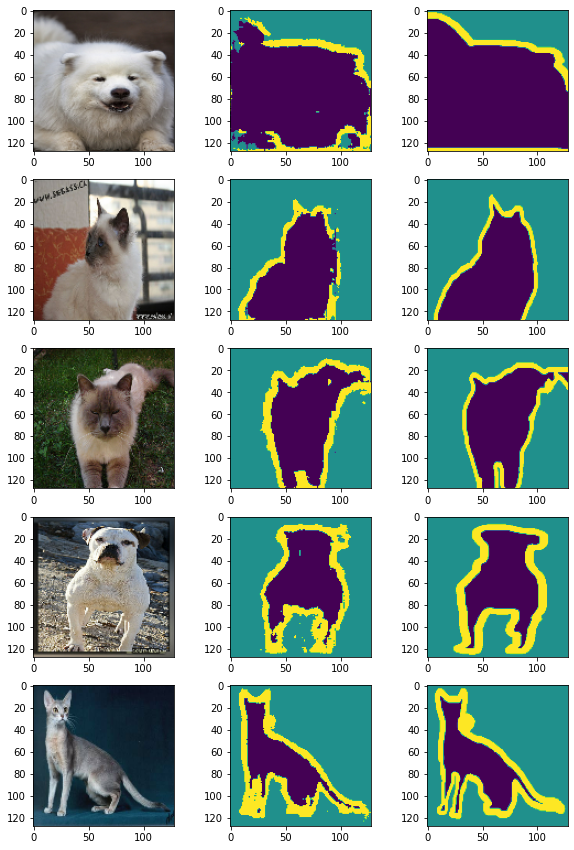

In [32]:
import matplotlib.pyplot as plt

for x,y in test_batch:
  break
pred = tf.argmax(unet.predict(x[:5]),axis=-1)
print(pred.shape)
fig,ax = plt.subplots(5,3,figsize=(10,15))
for i,(x,y,p) in enumerate(zip(x[:5],y[:5],pred)):
  ax[i,0].imshow(x)
  ax[i,1].imshow(p)
  ax[i,2].imshow(tf.reshape(y,(128,128)))
